## Weather Risk on Descartes Labs - Hurricane Ida Case Study

In August, 2021, Hurricane Ida made landfall centered on the US Gulf Coast State of Louisiana. This event was the worst to impact the region since 2005, [disrupting nearly 80% of the region's oil and gas production](https://www.reuters.com/business/energy/oil-losses-hurricane-ida-rank-among-worst-16-years-2021-09-07/). 

#### _Objective:_ 
Demonstrate how the Descartes Labs Platform can enable large scale feature-to-raster annotation by exploring the spatiotemporal impacts of this event in more detail. Here we will annotate ~7,000 offshore rig facilities provided by the [Bureau of Ocean Energy Management](https://www.data.boem.gov/Main/Platform.aspx) with 2 months of daily [Climate Forecast System weather conditions](https://www.ncei.noaa.gov/products/weather-climate-models/climate-forecast-system).

#### _What will we cover?_
* Exploratory analysis with the interactive computation engine [`Dynamic Compute`](https://docs.descarteslabs.com/api/dynamic-compute.html)
* Working with both the raster [`Catalog`](https://docs.descarteslabs.com/descarteslabs/catalog/readme.html) and [`Vector`](https://docs.descarteslabs.com/descarteslabs/vector/readme.html) tables
* Creating, iterating on, and managing highly scalable asynchronous [`Batch Compute`](https://docs.descarteslabs.com/descarteslabs/compute/readme.html) functions

In [1]:
import descarteslabs as dl
import descarteslabs.dynamic_compute as dc

from descarteslabs.catalog import Blob, Product, properties as p
from descarteslabs.compute import Function
from descarteslabs.vector import Table

In [2]:
import json
import rasterio
import sys
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt

In [3]:
org = dl.auth.Auth().payload["org"]
user_id = dl.auth.Auth().namespace

In [4]:
major = sys.version_info.major
minor = sys.version_info.minor
compute_image = f"python{major}.{minor}:latest"
compute_image

'python3.9:latest'

Setting global variables:

In [5]:
# Take these directly from Explorer:
pid = "ncep:cfsr-v2:daily:v1"
tid = "descarteslabs:offshore-rigs-boem"

bands = ["prec", "u_wind_10m", "v_wind_10m"]

start = "2021-08-01"
end = "2021-09-30"

## Interactive Visualization with Dynamic Compute

DC enables lightweight, interactive computation paired with an [ipyleaflet](https://ipyleaflet.readthedocs.io/en/latest/index.html) web map for  data exploration and hypothesis testing without the need to set up your own tile server:

In [6]:
m = dc.map
m.center = 28.4204, -91.5167
m.zoom = 6

First we'll set an [`ImageStack`](https://github.com/descarteslabs/example-notebooks.git) referencing the 12-day period surrounding landfall:

In [7]:
## Looking just at this event
stack = dc.ImageStack.from_product_bands(
    pid, bands, start_datetime="2021-08-20", end_datetime="2021-09-02"
)

Here we visualize a _sum_ of precip through the 12-day period:

In [8]:
stack.pick_bands("prec").sum(axis="images").visualize("Sum Precipitation (0.1mm)", m)

And _max_ wind speed through the same period:

In [9]:
u, v = stack.unpack_bands("u_wind_10m v_wind_10m")
ws = dc.sqrt(u**2 + v**2)
ws.max(axis="images").visualize("Max Wind Speed (0.01m/s)", m)

Next retrieve our offshore oil rigs as a [`Table`](https://docs.descarteslabs.com/descarteslabs/vector/readme.html#descarteslabs.vector.Table):

In [10]:
table = Table.get(tid)
table.count()

7314

In [11]:
table.visualize(
    "BOEM Offshore Rigs",
    m,
    vector_tile_layer_styles={"radius": 0.25, "color": "#FFA500"},
)

In [12]:
m


`ipyleaflet` and/or `ipywidgets` Jupyter extensions are not installed! (or you're not in a Jupyter notebook.)
To install for JupyterLab, run this in a cell:
    !jupyter labextension install jupyter-leaflet @jupyter-widgets/jupyterlab-manager
To install for plain Jupyter Notebook, run this in a cell:
    !jupyter nbextension enable --py --sys-prefix ipyleaflet
Then, restart the kernel and refresh the webpage.


### Scaling on Batch Compute

Below we outline a simple methodology of timeseries data extraction on the Descartes Labs Platform. The general steps are as follows:
1. Search and retrieve an [`ImageCollection`](https://docs.descarteslabs.com/descarteslabs/catalog/docs/image.html#descarteslabs.catalog.ImageCollection) over our offshore rigs filtering to the input date range, August to September, 2021
2. Define an asynchronous [`Function`](https://docs.descarteslabs.com/descarteslabs/compute/readme.html#descarteslabs.compute.Function) which accepts an [`Image`](https://docs.descarteslabs.com/descarteslabs/catalog/docs/image.html#descarteslabs.catalog.Image) ID as an input argument and:
    * Retrieves the intersecting point features
    * Rasters **precipitation** and **wind u + v components** from the weather data
    * Returns the intersected pixel values for each feature location alongside feature UUIDs

Retrieving dataframe from the table:

In [13]:
gdf = table.collect()
gdf.head(1)

,geometry,STR_NUMBER,COMPLEX_ID,STR_NAME,uuid
0,POINT (-96.26316 28.24569),1,10321,11,59e5891d-e332-45fd-be71-872c6fdc1c23


Searching and retrieving our imagery:

In [14]:
prod = Product.get(pid)
ic = (
    prod.images().intersects(box(*gdf.total_bounds)).filter(start <= p.acquired <= end)
).collect()
ic

ImageCollection of 61 images
  * Dates: Aug 01, 2021 to Sep 30, 2021
  * Products: ncep:cfsr-v2:daily:v1: 61

Inspecting the first image:

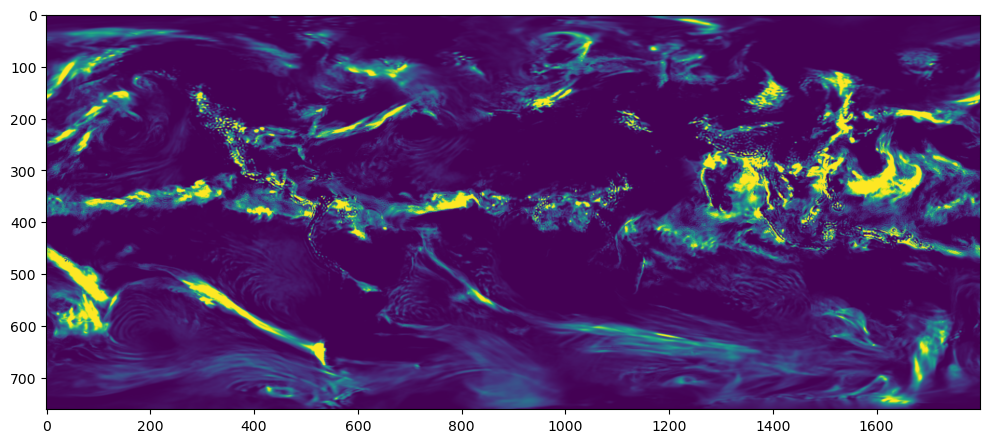

In [15]:
dl.utils.display(ic[0].ndarray("prec"), colormap="viridis")

Here we define our local Python function to iterate through each individual image, extract pixel values for each intersected feature, and returns as a dictionary alongside each unique ID:

In [16]:
def get_point_values(img_id, bands):
    import os
    import rasterio
    import numpy as np
    import descarteslabs as dl
    from descarteslabs.catalog import Image
    from descarteslabs.vector import Table

    def wind_speed(u, v):
        return np.sqrt(np.square(u) + np.square(v))

    # Retrieve our Table's vector data as a GDF
    table = Table.get("descarteslabs:offshore-rigs-boem")
    gdf = table.collect()
    # Create our Image
    img = Image.get(img_id)
    print(f"Retrieved {img_id}")

    date = img.acquired.strftime("%Y-%m-%d")
    gdf = gdf.to_crs(img.geocontext.crs)

    # Download our Image data
    img.download(bands, dest="temp.tif", format="tif")

    print("Downloaded")
    # Open the dataset
    with rasterio.open("temp.tif") as dataset:
        x = gdf["geometry"].x
        y = gdf["geometry"].y
        xy = np.dstack((x, y))[0]
        print("Sampling...")
        # Running sample, returning stacked array
        xy_vals = np.vstack(list(dataset.sample(xy)))

    # Returning UUIDs of our input dataset
    uuids = gdf["uuid"].values.tolist()

    # Setting up output dictionary
    out_dict = {"date": date, "data": {"uuid": uuids}}

    # For each band we create a field in the output dict:
    for i, band in enumerate(bands):
        out_dict["data"][band] = xy_vals[:, i].tolist()

    # Calculating wind speed from our wind components
    if "u_wind_10m" in bands and "v_wind_10m" in bands:
        print("Calculating Wind Speed")
        out_dict["data"]["wind_speed"] = wind_speed(
            out_dict["data"]["u_wind_10m"], out_dict["data"]["v_wind_10m"]
        ).tolist()
    print("Complete")
    # Cleaning up
    os.remove("temp.tif")
    return out_dict

At this point we test the function locally to iterate on and prove our methodology.

Let's look at our conditions on the first of August:

Retrieved ncep:cfsr-v2:daily:v1:cfsr-v2_ALL_20210801
Downloaded
Sampling...
Calculating Wind Speed
Complete


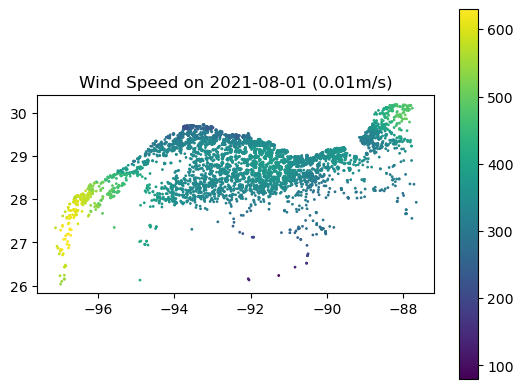

In [17]:
res_dict = get_point_values(ic[0].id, ["prec", "u_wind_10m", "v_wind_10m"])
res_df = pd.DataFrame(res_dict["data"])
gdf.merge(res_df, on="uuid").plot("wind_speed", legend=True, markersize=1)
plt.title(f"Wind Speed on {res_dict['date']} (0.01m/s)");

Now we can define an asynchronous Batch Compute [`Function`](https://docs.descarteslabs.com/descarteslabs/compute/readme.html#descarteslabs.compute.Function) which accepts several scaling parameters, notably:
* Number of **CPU**s per job
* Total **memory** per job
* Up to 1000 job **maximum_concurrency**

In [18]:
async_func = Function(
    get_point_values,
    name="CFSR Daily Weather",
    image=compute_image,
    cpus=1,
    memory=4,
    timeout=900,
    maximum_concurrency=100,
    retry_count=0,
)

async_func.save()
print(f"Saved {async_func.id}")

Saved 6734bce2-bf8f-473d-9dc2-ecac84b843e0


Here we format an iterable of input **(image_id, bands)** for our asynchronous function:

In [19]:
args = [(img_id, bands) for img_id in ic.each.id]
args[0]

('ncep:cfsr-v2:daily:v1:cfsr-v2_ALL_20210801',
 ['prec', 'u_wind_10m', 'v_wind_10m'])

And submit for processing:

In [20]:
jobs = async_func.map(args)
len(jobs)

61

Now we must wait for our function to complete. We suggest navigating to [app.descarteslabs.com/compute](https://app.descarteslabs.com/compute) to monitor progress in real time or you can wait programmatically via:

    async_func.wait_for_completion()

Once all of the [`Job`](https://docs.descarteslabs.com/descarteslabs/compute/readme.html#descarteslabs.compute.Job)s have completed successfully, we can retrieve each individual result as a [`Blob`](https://docs.descarteslabs.com/descarteslabs/catalog/docs/blob.html#descarteslabs.catalog.Blob):

In [21]:
print(f"Results for {async_func.id}")
res_list = []
for b in (
    Blob.search()
    .filter(p.namespace == f"{org}:{user_id}")
    .filter(p.name.startswith(async_func.id))
    .filter(p.storage_type == "compute")
):
    res = json.loads(b.data())
    res_date = res["date"]
    res_df = pd.DataFrame(res["data"])
    res_df["date"] = pd.to_datetime(res_date)
    res_list.append(res_df)

print(f"Retrieved {len(res_list)} results")

Results for 6734bce2-bf8f-473d-9dc2-ecac84b843e0
Retrieved 61 results


And now we have our time series results!

In [22]:
res_df = pd.concat(res_list)
res_df.shape

(446154, 6)

At this point we have completed our time-series data extraction. Here are a few simple summary plots to visualize our results:

Joining results to our input GDF:

In [23]:
res_gdf = gdf.merge(res_df, on="uuid", how="outer").set_index("date")
res_gdf["prec"] = res_gdf["prec"] * 0.1  # 0.1mm > mm
res_gdf["wind_speed"] = res_gdf["wind_speed"] * 0.01  # 0.01m/s > m/s

Retrieving a counties dataframe over our study AOI:

In [24]:
counties_table = Table.get(
    "descarteslabs:hifld:us-counties", aoi=box(*(-98, 25, -87, 30.5))
)
counties_gdf = counties_table.collect()

Summarizing max windspeed and sum of precipitation:

In [25]:
max_ws = res_gdf.groupby("uuid")["wind_speed"].max().reset_index()
sum_precip = res_gdf.groupby("uuid")["prec"].sum().reset_index()

And a few plots:

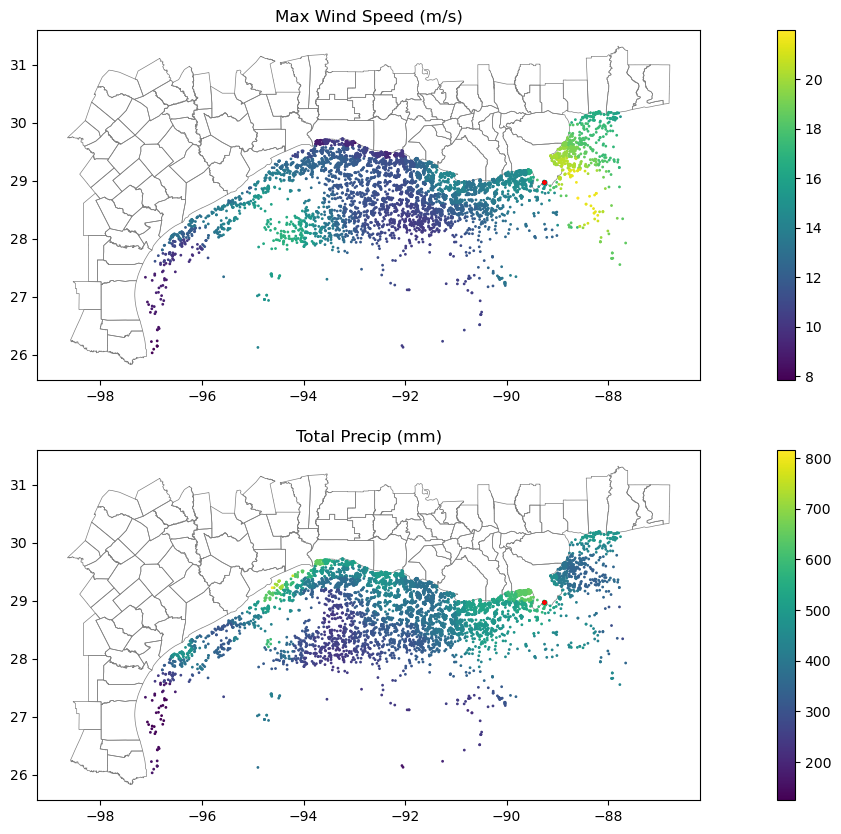

In [26]:
fig, ax = plt.subplots(figsize=(20, 10), nrows=2, ncols=1)
counties_gdf.plot(ax=ax[0], facecolor="none", edgecolor="grey", linewidth=0.5)
counties_gdf.plot(ax=ax[1], facecolor="none", edgecolor="grey", linewidth=0.5)
gdf.merge(max_ws, on="uuid").plot("wind_speed", legend=True, ax=ax[0], markersize=1)
ax[0].set_title("Max Wind Speed (m/s)")
gdf.merge(sum_precip, on="uuid").plot("prec", legend=True, ax=ax[1], markersize=1)
ax[1].set_title("Total Precip (mm)")
res_gdf[res_gdf["uuid"] == "83c39701-56e8-40c0-8e0d-2f475f5bab5d"].plot(
    ax=ax[0], markersize=2, color="r"
)
res_gdf[res_gdf["uuid"] == "83c39701-56e8-40c0-8e0d-2f475f5bab5d"].plot(
    ax=ax[1], markersize=2, color="r"
);

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10), nrows=2, ncols=1)
res_gdf[
    res_gdf["uuid"] == "83c39701-56e8-40c0-8e0d-2f475f5bab5d"
].reset_index().plot.scatter("date", "prec", ax=ax[0], marker='o-')
res_gdf[
    res_gdf["uuid"] == "83c39701-56e8-40c0-8e0d-2f475f5bab5d"
].reset_index().plot.scatter("date", "wind_speed", ax=ax[1])
ax[0].axvline(pd.to_datetime("2021-08-29"), color="r")
ax[1].axvline(pd.to_datetime("2021-08-29"), color="r")